In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
import random
from tqdm import trange

warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

In [3]:
# Load Data
train_raw = pd.read_csv('../Data/UNSW-NB15/train.csv')
print(train_raw.shape)
test_raw = pd.read_csv('../Data/UNSW-NB15/test.csv')
print(test_raw.shape)

(82332, 45)
(175341, 45)


In [4]:
# Seperate label and Drop ID
train_X = train_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
train_Y = train_raw['attack_cat']
test_X = test_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
test_Y = test_raw['attack_cat']

In [5]:
# Normalize data with min, max of training data
test_X1 = (test_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
train_X1 = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))

test_X1[test_X1 < 0] = 0
test_X1[test_X1 > 1] = 1

In [6]:
# Encode label as discrete numbers
encoder = LabelEncoder()
train_Y1 = encoder.fit_transform(train_Y)
test_Y1 = encoder.transform(test_Y)

In [7]:
# estimite time consumption of model trainin/testing with different number of features
train_times_all = []
test_times_all = []
f1_all = []

model = LogisticRegression(max_iter=10000, random_state=0)
for i in range(10):
    cols = []
    candidates = train_X1.columns.to_list()
    train_times = []
    test_times = []
    f1s = []
    train_X2 = pd.DataFrame()
    test_X2 = pd.DataFrame()

    for k in trange(train_X1.shape[1]-1):
        # randomly choose a feature and add to the subset
        f = random.choice(candidates)
        candidates.remove(f)
        train_X2[f] = train_X1[f].copy()
        test_X2[f] = test_X1[f].copy()
        # measure time of model training
        second = time.time()
        model.fit(train_X2, train_Y1)
        second2 = time.time()
        train_times.append(second2 - second)
        # measure time of model testing
        second = time.time()
        predict = model.predict(test_X2)
        second2 = time.time()
        f1s.append(f1_score(test_Y1, predict, average='macro'))
        test_times.append(second2 - second)

    train_times_all.append(train_times)
    test_times_all.append(test_times)
    f1_all.append(f1s)

100%|██████████| 38/38 [09:33<00:00, 15.08s/it]


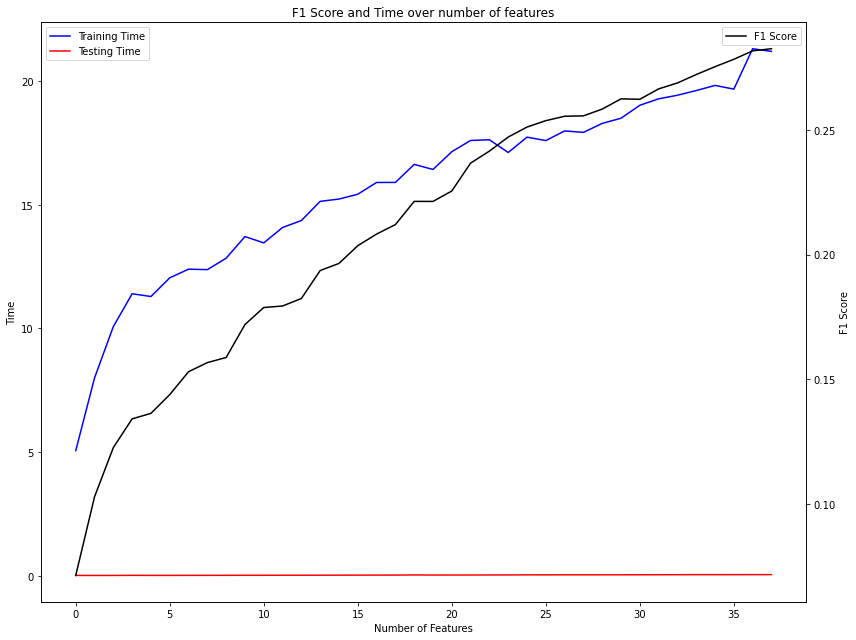

In [9]:
fig, ax = plt.subplots(figsize=(12, 9))
plt.title('F1 Score and Time over number of features')

ax2 = ax.twinx()
ax.set_xlabel('Number of Features')
ax.set_ylabel('Time')
ax2.set_ylabel('F1 Score')

ax.plot(range(train_X2.shape[1]), np.array(train_times_all).mean(axis=0), color='blue', linestyle='-', label='Training Time')
ax.plot(range(train_X2.shape[1]), np.array(test_times_all).mean(axis=0), color='red', linestyle='-', label='Testing Time')
ax2.plot(range(train_X2.shape[1]), np.array(f1_all).mean(axis=0), color='black', linestyle='-', label='F1 Score')

ax.legend()
ax2.legend()
plt.tight_layout()
plt.show()